## Fetching a NEXRAD file and extracting a column

<a href='https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long'> This Stack overflow post </a> Gives a way to get the range and azimuth between two lat lon points. 

For our example here we are going to use the ARM deployment to Houston as an example and extract a column over ARM site at La Porte from the KHGX NEXRAD volume.


In [250]:
import nexradaws
import tempfile
import os
import shutil
import pyart
import pytz
import pyproj
from datetime import datetime, timedelta
import act

import cftime
import pandas as pd

import xarray as xr

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np

from geographiclib.geodesic import Geodesic



In [11]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def get_my_radar(connex, site, this_datetime):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(this_datetime.year,this_datetime.month, this_datetime.day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = this_datetime
    
    #Need to clean
    these_good_scans = []
    these_good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            these_good_times.append(these_times[i])
            these_good_scans.append(these_scans[i])
    
    print(len(these_good_scans), len(these_good_times))

    this_nearest_time = nearest(these_good_times, targ)
    this_index = these_good_times.index(this_nearest_time)
    lcn = tlocation
    localfiles = conn.download(these_good_scans[this_index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

In [52]:
conn = nexradaws.NexradAwsInterface()
recent_time = datetime(2021, 9, 29, 11, 30, 0).replace(tzinfo=pytz.UTC)

my_radar = get_my_radar(conn, 'KHGX', recent_time)

181 181
Downloaded KHGX20210929_112914_V06
1 out of 1 files downloaded...0 errors


Lets check the location of our radar!

In [53]:
print(my_radar.longitude)
print(my_radar.latitude)


{'long_name': 'Longitude', 'standard_name': 'Longitude', 'units': 'degrees_east', 'data': array([-95.07873535])}
{'long_name': 'Latitude', 'standard_name': 'Latitude', 'units': 'degrees_north', 'data': array([29.47190094])}


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

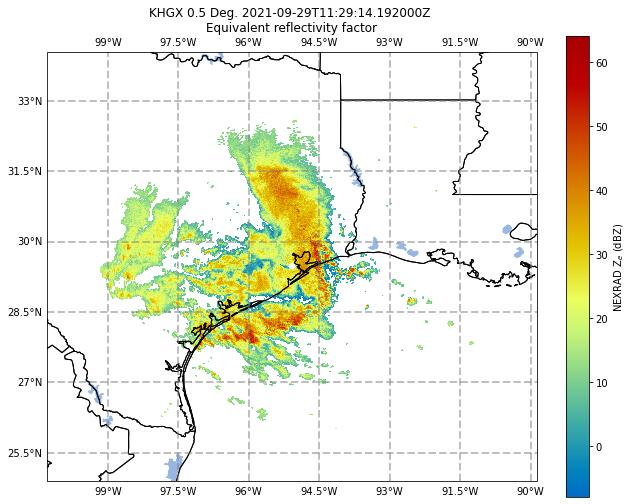

In [54]:
myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(my_radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)

HOU M1: La Porte, Texas
HOU M1 Latitude:   29.67
HOU M1 Longitude: -95.059
HOU M1 Altitude:    8


In [62]:
site_lat = 29.67
site_lon = -95.059
radar_lat = my_radar.latitude['data'][0]
radar_lon = my_radar.longitude['data'][0]



/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

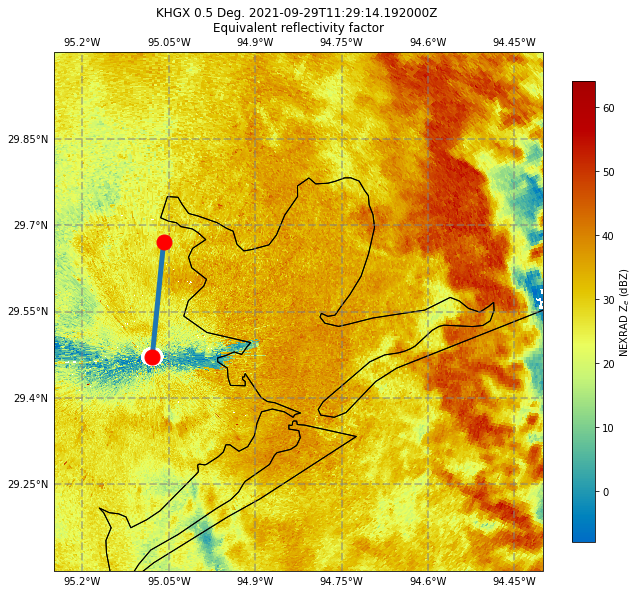

In [56]:
myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(my_radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, 
                 colorbar_flag=False)

plt.xlim(-95.25,-94.4)
plt.ylim(29.1, 30.)

ax.plot([site_lon, radar_lon], [site_lat, radar_lat], linewidth=5.0)
ax.plot([site_lon, radar_lon], [site_lat, radar_lat], 'ro', markersize=15.0)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)

In [69]:
rng = Geodesic.WGS84.Inverse(radar_lat, radar_lon, site_lat , site_lon)['s12']
brg = Geodesic.WGS84.Inverse(radar_lat, radar_lon, site_lat , site_lon)['azi1']


In [70]:
print(rng, brg)

22041.4525369963 4.972403237818765


In [117]:
debug = False

#empty list for the values
vals = []

#Keys, or fields, in the radar file.. what values do we want to extract
rkeys = my_radar.fields.keys()

#Loop over all sweeps.. Assumes a PPI
for i in range(len(my_radar.sweep_end_ray_index['data'])):
    
    #grab a sweep
    sweep = my_radar.extract_sweeps([i])
    
    #work out the index of the nearest azimuth to the azimuth we are searching for
    az_num = list(sweep.azimuth['data']).index(nearest(sweep.azimuth['data'], brg))
    
    if debug:
        print(az_num, sweep.azimuth['data'][az_num])
    
    #work out the distance along the ground of the radar gates
    distance_along_ground = np.sqrt(sweep.gate_x['data']**2 + sweep.gate_y['data']**2 )[az_num, :]
    
    #Work out the index of the closest gate
    gate_num = list(distance_along_ground).index(nearest(distance_along_ground, rng))
    
    if debug:
        print(gate_num, distance_along_ground[gate_num])
    
    #This nasty bit of code makes a dictionary with the required gate value for that sweep
    gate_vals =  dict([(thiskey, sweep.fields[thiskey]['data'][az_num, gate_num]) for thiskey in rkeys])
    
    #Construct a dictionary of information about the radar gate
    loc_info = {'range': sweep.range['data'][gate_num],
               'lat' : sweep.gate_latitude['data'][az_num, gate_num],
               'lon' : sweep.gate_longitude['data'][az_num, gate_num],
               'height' : sweep.gate_altitude['data'][az_num, gate_num],
               'time' : sweep.time['data'][az_num],
               'time_units' : sweep.time['units']}
    vals.append({'loc_info' : loc_info, 'fields' : gate_vals})
    

In [240]:
vals[0]

{'loc_info': {'range': 22125.0,
  'lat': 29.670182118076184,
  'lon': -95.05978890625622,
  'height': 232.0,
  'time': 13.50800000000163,
  'time_units': 'seconds since 2021-09-29T11:29:14Z'},
 'fields': {'velocity': masked,
  'differential_reflectivity': 0.25,
  'spectrum_width': masked,
  'differential_phase': 66.28821,
  'cross_correlation_ratio': 0.9916667,
  'reflectivity': 28.5,
  'clutter_filter_power_removed': -6.0}}

In [258]:
column = {}
heights =  np.array([vals[i]['loc_info']['height'] for i in range(len(vals))])
indx = heights.argsort()
heights = heights[indx]

time_vals =  np.array([vals[i]['loc_info']['time'] for i in range(len(vals))])
dt_array = cftime.num2pydate(time_vals, vals[0]['loc_info']['time_units'])[indx]


for kval in vals[0]['fields'].keys():
    column.update({kval: np.array([vals[i]['fields'][kval] for i in range(len(vals)) ])[indx]})



    

/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()


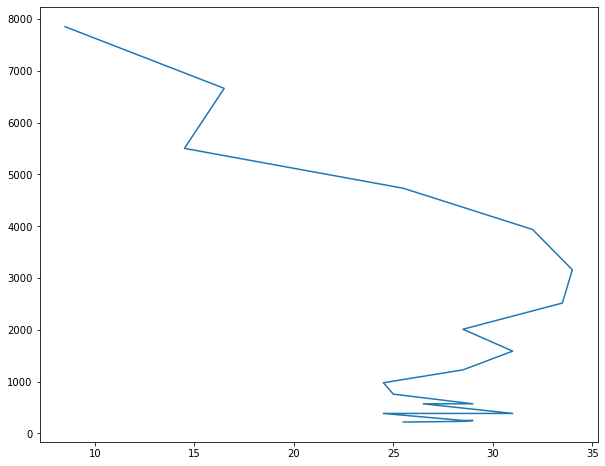

In [253]:
figme = plt.figure(figsize=[10,8])
plt.plot(column['reflectivity'], heights)

## Now lets put it in a function

In [260]:
def get_column_from_NEXRAD(site_location_lat_lon, date_time_requested, radar_site, debug=False,
                          conn=None):
    #ToDo: Write docstring :)
    
    #See if we have a connecton. If not open one
    if conn == None:
        conn = nexradaws.NexradAwsInterface()
        connected = True
    
    #load a radar
    the_radar = get_my_radar(conn, radar_site, date_time_requested)
    
    #get the radar location. Assume it is a stationary platform
    radar_lat = the_radar.latitude['data'][0]
    radar_lon = the_radar.longitude['data'][0]
    
    #Get range and bearing of the site from the radar
    rng = Geodesic.WGS84.Inverse(radar_lat, radar_lon, 
                                 site_location_lat_lon[0] , site_location_lat_lon[1])['s12']
    brg = Geodesic.WGS84.Inverse(radar_lat, radar_lon, 
                                 site_location_lat_lon[0] , site_location_lat_lon[1])['azi1']
    
    #empty list for the values
    vals = []

    #Keys, or fields, in the radar file.. what values do we want to extract
    rkeys = the_radar.fields.keys()

    #Loop over all sweeps.. Assumes a PPI

    for i in range(the_radar.nsweeps):
        #grab a sweep
        sweep = the_radar.extract_sweeps([i])
        
        #work out the index of the nearest azimuth to the azimuth we are searching for
        az_num = list(sweep.azimuth['data']).index(nearest(sweep.azimuth['data'], brg))
        
        if debug:
            print(az_num, sweep.azimuth['data'][az_num])
        
        #work out the distance along the ground of the radar gates
        distance_along_ground = np.sqrt(sweep.gate_x['data']**2 + sweep.gate_y['data']**2 )[az_num, :]
        
        #Work out the index of the closest gate
        gate_num = list(distance_along_ground).index(nearest(distance_along_ground, rng))
        
        if debug:
            print(gate_num, distance_along_ground[gate_num])
        
        #This nasty bit of code makes a dictionary with the required gate value for that sweep
        gate_vals =  dict([(thiskey, sweep.fields[thiskey]['data'][az_num, gate_num]) for thiskey in rkeys])

        #Construct a dictionary of information about the radar gate
        loc_info = {'range': sweep.range['data'][gate_num],
                   'lat' : sweep.gate_latitude['data'][az_num, gate_num],
                   'lon' : sweep.gate_longitude['data'][az_num, gate_num],
                   'height' : sweep.gate_altitude['data'][az_num, gate_num],
                   'time' : sweep.time['data'][az_num],
                   'time_units' : sweep.time['units']}
        vals.append({'loc_info' : loc_info, 'fields' : gate_vals})
        
        
    #Repack the data into numpy arrays
        
    column = {}

    #Grab the heights first and then create an index array to sort by height
    heights =  np.array([vals[i]['loc_info']['height'] for i in range(len(vals))])
    indx = heights.argsort()
    heights = heights[indx]

    time_vals =  np.array([vals[i]['loc_info']['time'] for i in range(len(vals))])
    dt_array = cftime.num2pydate(time_vals, vals[0]['loc_info']['time_units'])[indx]

    lats = np.array([vals[i]['loc_info']['lat'] for i in range(len(vals))])[indx]
    lons = np.array([vals[i]['loc_info']['lat'] for i in range(len(vals))])[indx]

    #Grab the field data with an UGLY generator
    for kval in vals[0]['fields'].keys():
        column.update({kval: np.array([vals[i]['fields'][kval] for i in range(len(vals)) ])[indx]})

    return heights, dt_array, lats, lons, column


    
    
    

In [261]:
test_time = datetime(2021, 9, 29, 11, 30, 0).replace(tzinfo=pytz.UTC)

this_heights, this_dt, this_lats, this_lons, this_column = get_column_from_NEXRAD((site_lat, site_lon),
                                                                                 test_time, 'KHGX')

243 243
Downloaded KHGX20210929_112914_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


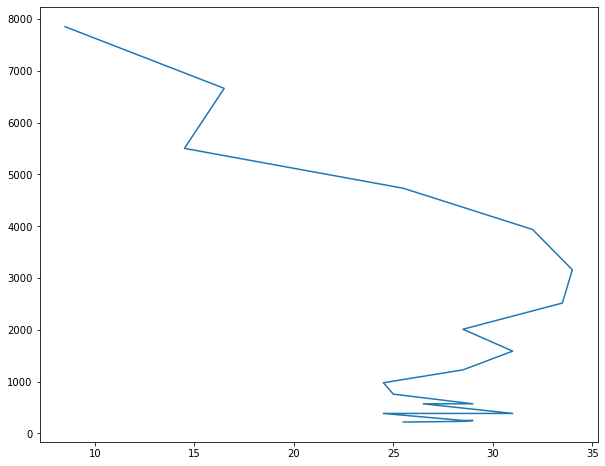

In [262]:
figme = plt.figure(figsize=[10,8])
plt.plot(this_column['reflectivity'], this_heights)

243 243
Downloaded KHGX20210929_110141_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


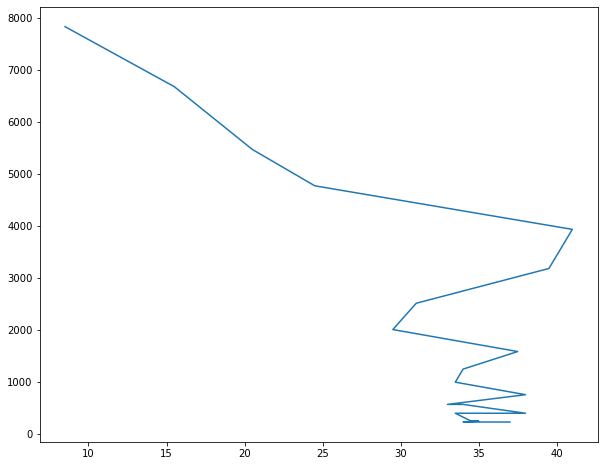

In [263]:
test_time = datetime(2021, 9, 29, 11, 0, 0).replace(tzinfo=pytz.UTC)

this_heights, this_dt, this_lats, this_lons, this_column = get_column_from_NEXRAD((site_lat, site_lon),
                                                                                 test_time, 'KHGX')

igme = plt.figure(figsize=[10,8])
plt.plot(this_column['reflectivity'], this_heights)

In [276]:
the_day = datetime(2021, 9, 29)

connex = nexradaws.NexradAwsInterface()
these_scans = connex.get_avail_scans(the_day.year, the_day.month, the_day.day, 'KHGX')
these_times = [scan.scan_time for scan in these_scans]

In [329]:
stormy_times = these_times[80:130] 
print(stormy_times)

[datetime.datetime(2021, 9, 29, 8, 12, 6, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 8, 19, 2, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 8, 25, 59, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 8, 35, 12, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 8, 42, 8, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 8, 49, 11, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 8, 56, 8, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 8, 56, 8, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 3, 12, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 10, 16, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 17, 20, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 24, 24, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 31, 23, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 38, 19, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 45, 15, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 52, 25, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 59, 27, tzinfo=<UTC>), datetime.datetime(2021, 9, 29, 9, 59

In [330]:
cols = []
times = []
hts = []
for party_time in stormy_times:
    this_heights, this_dt, this_lats, this_lons, this_column = get_column_from_NEXRAD((site_lat, site_lon),
                                                                                      party_time, 'KHGX')
    
    cols.append(this_column)
    times.append(this_dt)
    hts.append(this_heights)

    

243 243
Downloaded KHGX20210929_081206_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_081902_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_082559_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_083512_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_084208_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_084911_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_085608_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_085608_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_090312_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_091016_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_091720_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_092424_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_093123_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_093819_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_094515_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_095225_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_095927_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_095927_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_100631_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_101328_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_102025_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_102716_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_103414_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_104106_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_104758_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_105449_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_105449_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_110141_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_110831_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_111523_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_112216_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_112914_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_113622_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_114319_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_115018_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_115715_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_115715_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_120413_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_121104_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_121756_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_122515_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_123206_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_123904_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_124609_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_125313_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_125313_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_130017_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_130735_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_131444_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


243 243
Downloaded KHGX20210929_132201_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.


In [331]:
for i in range(len(hts)):
    print(len(hts[i]), len(cols[i]['reflectivity']))

20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20


In [332]:
hts[10]

array([ 249.,  249.,  249.,  249.,  401.,  401.,  571.,  571.,  758.,
        978., 1250., 1669., 2011., 2517., 3159., 3925., 4735., 5526.,
       6673., 7860.])

In [333]:
number_of_exes = 19
my_exes = np.linspace(200,9000, number_of_exes)
th_z = np.zeros((number_of_exes, len(hts)))
for i in range(len(hts)):
    th_z[:, i] = np.interp(my_exes, hts[i], cols[i]['reflectivity'])
    

In [334]:
plotting_times = [this_time[0] for this_time in times]

/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


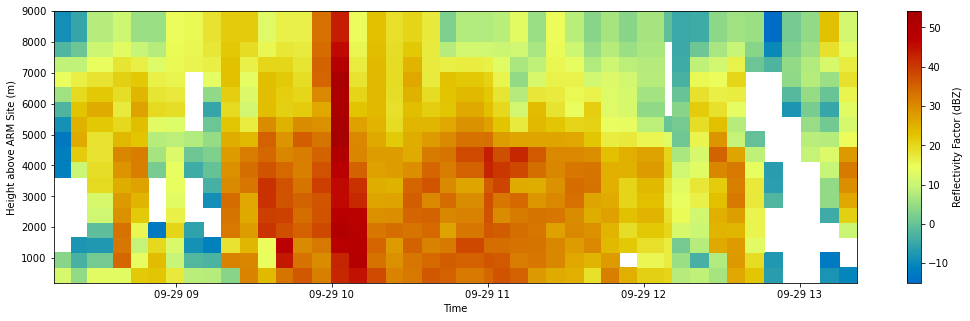

In [338]:

igme = plt.figure(figsize=[18,5])
plt.pcolormesh(plotting_times, my_exes, th_z, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.ylabel('Height above ARM Site (m)')
plt.xlabel('Time')
plt.colorbar(label='Reflectivity Factor (dBZ)')

In [226]:
th_z.transpose().shape

(19, 20)

In [232]:
a = plotting_times[0]

In [235]:
pd.to_datetime(a)

TypeError: <class 'cftime._cftime.DatetimeGregorian'> is not convertible to datetime